# Direct Forecasting with future known features

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we carry out **direct forecasting** to predict multiple steps into the future by combining the use of features from past values of the time series with features whose future values we know.

SKForecast produces lags out of the box. And we can combine SKForecast with Feature-engine to create more features.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline

from skforecast.direct import ForecasterDirect

from feature_engine.datetime import DatetimeFeatures

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [ ]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [3]:
df.tail()

,demand
date_time,
2015-02-28 19:00:00,9596.777060
2015-02-28 20:00:00,8883.230296
2015-02-28 21:00:00,8320.260550
2015-02-28 22:00:00,8110.055916
2015-02-28 23:00:00,8519.368752


In [4]:
# Split into train and test

# We leave the last February in the test set

end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

## Plot time series

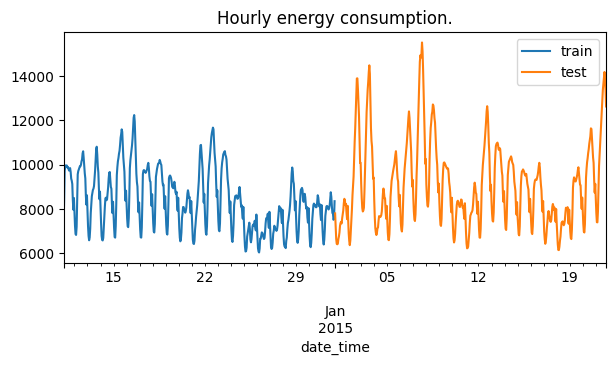

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
X_train.tail(500).plot(ax=ax)
X_test.head(500).plot(ax=ax)
ax.set_title('Hourly energy consumption.')
ax.legend(["train", "test"])
plt.show()

## Regression model

In [6]:
model = GradientBoostingRegressor(random_state=9, max_depth=3, n_estimators=5) 

## Future known values: datetime

We'll add datetime features.

In [7]:
# the template data that we'll use to create those
# features

datetime_df = pd.DataFrame(X_train.index, index=X_train.index)

datetime_df

,date_time
date_time,
2002-01-01 00:00:00,2002-01-01 00:00:00
2002-01-01 01:00:00,2002-01-01 01:00:00
2002-01-01 02:00:00,2002-01-01 02:00:00
2002-01-01 03:00:00,2002-01-01 03:00:00
2002-01-01 04:00:00,2002-01-01 04:00:00
...,...
2014-12-31 19:00:00,2014-12-31 19:00:00
2014-12-31 20:00:00,2014-12-31 20:00:00
2014-12-31 21:00:00,2014-12-31 21:00:00


In [8]:
# set the datetime features.

datetime_f = DatetimeFeatures(
    variables="date_time",
    features_to_extract=["month", "day_of_week", "hour"],
    drop_original=True,
)

# test

datetime_f.fit_transform(datetime_df)

,date_time_month,date_time_day_of_week,date_time_hour
date_time,,,
2002-01-01 00:00:00,1,1,0
2002-01-01 01:00:00,1,1,1
2002-01-01 02:00:00,1,1,2
2002-01-01 03:00:00,1,1,3
2002-01-01 04:00:00,1,1,4
...,...,...,...
2014-12-31 19:00:00,12,2,19
2014-12-31 20:00:00,12,2,20
2014-12-31 21:00:00,12,2,21


## Direct forecaster

In [ ]:
forecaster = ForecasterDirect(
    regressor=model,              # the machine learning model
    lags=24,                      # the lag features to create
    transformer_exog=datetime_f,  # to get the datetime features
    steps=24,
    forecaster_id="direct",
)

In [10]:
forecaster.fit(
    y=X_train["demand"],  # the series for the lags
    exog=datetime_df,     # the datetime for the datetime features
)

forecaster

ForecasterAutoregDirect 
Regressor: GradientBoostingRegressor(n_estimators=5, random_state=9) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'hour'],
                 variables='date_time') 
Weight function included: False 
Window size: 24 
Maximum steps predicted: 24 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['date_time'] 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_frac

## Input features to regression

In [11]:
Xt, yt = forecaster.create_train_X_y(
    y=X_train["demand"],
    exog=datetime_df,
)

Xt.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,date_time_hour_step_21,date_time_month_step_22,date_time_day_of_week_step_22,date_time_hour_step_22,date_time_month_step_23,date_time_day_of_week_step_23,date_time_hour_step_23,date_time_month_step_24,date_time_day_of_week_step_24,date_time_hour_step_24
date_time,,,,,,,,,,,,,,,,,,,,,
2002-01-02 23:00:00,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6490.669762,6221.417302,6013.496578,...,20,1,2,21,1,2,22,1,2,23
2002-01-03 00:00:00,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6490.669762,6221.417302,...,21,1,2,22,1,2,23,1,3,0
2002-01-03 01:00:00,6990.826420,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6490.669762,...,22,1,2,23,1,3,0,1,3,1
2002-01-03 02:00:00,6382.915018,6990.826420,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,...,23,1,3,0,1,3,1,1,3,2
2002-01-03 03:00:00,5896.928138,6382.915018,6990.826420,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,...,0,1,3,1,1,3,2,1,3,3


Now, look at this:

In [12]:
# the variables created by the direct forecaster:

[col for col in Xt.columns]

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'date_time_month_step_1',
 'date_time_day_of_week_step_1',
 'date_time_hour_step_1',
 'date_time_month_step_2',
 'date_time_day_of_week_step_2',
 'date_time_hour_step_2',
 'date_time_month_step_3',
 'date_time_day_of_week_step_3',
 'date_time_hour_step_3',
 'date_time_month_step_4',
 'date_time_day_of_week_step_4',
 'date_time_hour_step_4',
 'date_time_month_step_5',
 'date_time_day_of_week_step_5',
 'date_time_hour_step_5',
 'date_time_month_step_6',
 'date_time_day_of_week_step_6',
 'date_time_hour_step_6',
 'date_time_month_step_7',
 'date_time_day_of_week_step_7',
 'date_time_hour_step_7',
 'date_time_month_step_8',
 'date_time_day_of_week_step_8',
 'date_time_hour_step_8',
 'date_time_month_step_9',
 'date_time_day_of_week_step_9

Skforecast generates automatically the datetime features needed for each step of the horizon. 

Here an example for time step 4:

In [13]:
Xt[['date_time_hour_step_1', 'date_time_hour_step_2',
    'date_time_hour_step_3', 'date_time_hour_step_4',]].head()

,date_time_hour_step_1,date_time_hour_step_2,date_time_hour_step_3,date_time_hour_step_4
date_time,,,,
2002-01-02 23:00:00,0,1,2,3
2002-01-03 00:00:00,1,2,3,4
2002-01-03 01:00:00,2,3,4,5
2002-01-03 02:00:00,3,4,5,6
2002-01-03 03:00:00,4,5,6,7


Note that we now have multiple targets, one per step in the horizon as well.


In [14]:
yt

{1: date_time
 2002-01-02 00:00:00    6579.219880
 2002-01-02 01:00:00    6990.826420
 2002-01-02 02:00:00    6382.915018
 2002-01-02 03:00:00    5896.928138
 2002-01-02 04:00:00    5853.937140
                           ...     
 2014-12-30 20:00:00    8214.038608
 2014-12-30 21:00:00    7768.087674
 2014-12-30 22:00:00    7504.257620
 2014-12-30 23:00:00    8181.280682
 2014-12-31 00:00:00    7566.135266
 Freq: H, Name: y_step_1, Length: 113905, dtype: float64,
 2: date_time
 2002-01-02 01:00:00    6990.826420
 2002-01-02 02:00:00    6382.915018
 2002-01-02 03:00:00    5896.928138
 2002-01-02 04:00:00    5853.937140
 2002-01-02 05:00:00    6344.834628
                           ...     
 2014-12-30 21:00:00    7768.087674
 2014-12-30 22:00:00    7504.257620
 2014-12-30 23:00:00    8181.280682
 2014-12-31 00:00:00    7566.135266
 2014-12-31 01:00:00    6985.052416
 Freq: H, Name: y_step_2, Length: 113905, dtype: float64,
 3: date_time
 2002-01-02 02:00:00    6382.915018
 2002-01-02 03

Under the hood, to predict each step, skforecast will combine all the lags with the respective datetime features, and use those as input to the model.

If you add more variables to the `exog`, it will also know how to identify the value corresponding to each step of the horizon and use it to train a model for that particular step, and no other.

## Predict future data

We'll start by predicting the 24 hs right after the train set ends.

We need to create a window with the forecasting horizon. Or in other words, the template for the datetime features.

In [ ]:
forecast_point = '2015-01-01 00:00:00'
forecast_end = '2015-01-01 23:59:59'

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="1h",
)

index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               '2015-01-01 10:00:00', '2015-01-01 11:00:00',
               '2015-01-01 12:00:00', '2015-01-01 13:00:00',
               '2015-01-01 14:00:00', '2015-01-01 15:00:00',
               '2015-01-01 16:00:00', '2015-01-01 17:00:00',
               '2015-01-01 18:00:00', '2015-01-01 19:00:00',
               '2015-01-01 20:00:00', '2015-01-01 21:00:00',
               '2015-01-01 22:00:00', '2015-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [16]:
# for the exog

exog = pd.DataFrame(
    X_test.loc[index].index,
    columns = ["date_time"],
    index = index,
)

exog

,date_time
2015-01-01 00:00:00,2015-01-01 00:00:00
2015-01-01 01:00:00,2015-01-01 01:00:00
2015-01-01 02:00:00,2015-01-01 02:00:00
2015-01-01 03:00:00,2015-01-01 03:00:00
2015-01-01 04:00:00,2015-01-01 04:00:00
2015-01-01 05:00:00,2015-01-01 05:00:00
2015-01-01 06:00:00,2015-01-01 06:00:00
2015-01-01 07:00:00,2015-01-01 07:00:00
2015-01-01 08:00:00,2015-01-01 08:00:00
2015-01-01 09:00:00,2015-01-01 09:00:00


In [17]:
preds = forecaster.predict(
    steps=24,
    exog=exog,
)

preds

2015-01-01 00:00:00    8818.821535
2015-01-01 01:00:00    8685.728661
2015-01-01 02:00:00    8514.078942
2015-01-01 03:00:00    8454.310333
2015-01-01 04:00:00    8402.014879
2015-01-01 05:00:00    8402.057197
2015-01-01 06:00:00    8677.247195
2015-01-01 07:00:00    8774.429661
2015-01-01 08:00:00    8884.127718
2015-01-01 09:00:00    8884.135297
2015-01-01 10:00:00    8884.140646
2015-01-01 11:00:00    8774.460968
2015-01-01 12:00:00    8774.463544
2015-01-01 13:00:00    8774.468869
2015-01-01 14:00:00    8884.156268
2015-01-01 15:00:00    8884.171617
2015-01-01 16:00:00    8884.192678
2015-01-01 17:00:00    8884.206858
2015-01-01 18:00:00    8884.215545
2015-01-01 19:00:00    8774.552822
2015-01-01 20:00:00    8774.572113
2015-01-01 21:00:00    8774.579153
2015-01-01 22:00:00    8774.594348
2015-01-01 23:00:00    8884.289568
Name: pred, dtype: float64

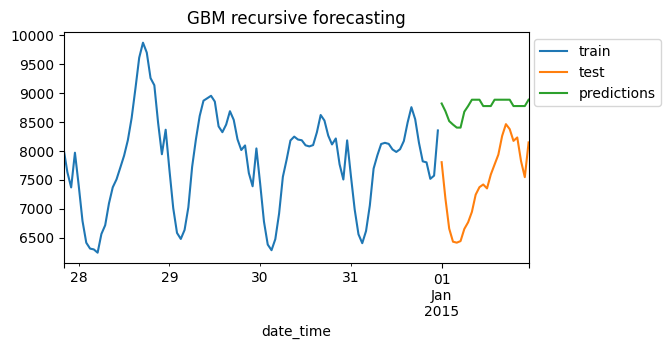

In [18]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(100)["demand"].plot(ax=ax, label='train')
X_test.loc[index]["demand"].plot(ax=ax, label='test')
preds.plot(ax=ax, label='predictions')
plt.title("GBM recursive forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [19]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test.loc[index]["demand"],
                y_pred = preds
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1977013.8626981936


In [20]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test.loc[index]["demand"],
                y_pred = preds
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 1406.0632498924767


## Predict any time point in the future

In [21]:
# Say we want to predict energy demand for 1st of February

forecast_start = '2015-02-01 00:00:00'

# we need the energy demand up to 144 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(24)

past_data_available.head()

,demand
date_time,
2015-01-31 00:00:00,7844.738566
2015-01-31 01:00:00,7164.501132
2015-01-31 02:00:00,6689.463174
2015-01-31 03:00:00,6553.640100
2015-01-31 04:00:00,6691.974048


In [22]:
# for the exog

exog = pd.DataFrame(
    X_test['2015-01-31 23:59:59':].head(24).index,
    columns = ["date_time"],
    index = X_test['2015-01-31 23:59:59':].head(24).index,
)

exog

,date_time
date_time,
2015-02-01 00:00:00,2015-02-01 00:00:00
2015-02-01 01:00:00,2015-02-01 01:00:00
2015-02-01 02:00:00,2015-02-01 02:00:00
2015-02-01 03:00:00,2015-02-01 03:00:00
2015-02-01 04:00:00,2015-02-01 04:00:00
2015-02-01 05:00:00,2015-02-01 05:00:00
2015-02-01 06:00:00,2015-02-01 06:00:00
2015-02-01 07:00:00,2015-02-01 07:00:00
2015-02-01 08:00:00,2015-02-01 08:00:00


In [23]:
predictions = forecaster.predict(
    steps=24,
    last_window=past_data_available["demand"],
    exog=exog,
)

predictions.head()

2015-02-01 00:00:00    8818.821535
2015-02-01 01:00:00    8685.728661
2015-02-01 02:00:00    8514.078942
2015-02-01 03:00:00    8454.310333
2015-02-01 04:00:00    8402.014879
Name: pred, dtype: float64

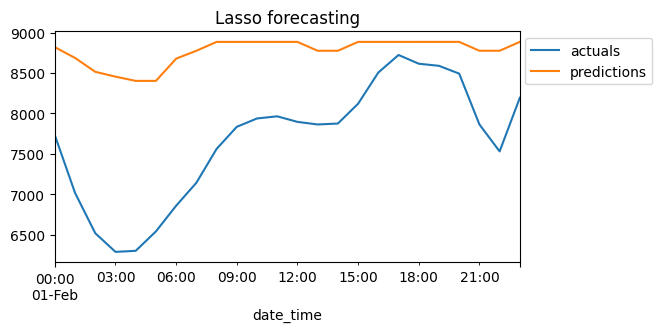

In [24]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_test['2015-01-31 23:59:59':].head(24)["demand"].plot(ax=ax, label='actuals')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [25]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test['2015-01-31 23:59:59':].head(24)["demand"],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1568250.4096934712


In [26]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test['2015-01-31 23:59:59':].head(24)["demand"],
                y_pred = predictions
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 1252.298051461181


That's it! Now you know how to combine the use of past values through lags with future known values like those extracted from datatime.